<a href="https://colab.research.google.com/github/Arthur-barretto/la_crime-data/blob/main/Crime_Data_Los_Angeles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

In [2]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import cm

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

sns.set_style('whitegrid')

In [3]:
#!pip install tensorflow --upgrade
#!pip install keras --upgrade
import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
#from sklearn.externals import joblib

In [4]:
import plotly.io as pio

# Enable notebook mode
pio.renderers.default = "colab"

# Import Data

## Crime Data

In [5]:
df = pd.read_csv('/content/drive/My Drive/Portfolio Projects/Crime Data - Los Angeles/Crime_Data_from_2020_to_Present_20241101.csv',sep = ',')

In [6]:
df.rename(columns={'DR_NO':'no','Date Rptd':'date report', 'DATE OCC':'date occ', 'TIME OCC':'time occ', 'Crm Cd Desc':'category', 'AREA':'area code', 'AREA NAME':'area', 'id':'district', 'LOCATION':'location', 'LAT':'lat','LON':'lon'},inplace=True)

df['lon_lat'] = df[['lon','lat']].values.tolist()

#No exact hour of ocurrence
len(df[df['date occ'].apply(lambda x: x[-11:] != '12:00:00 AM')])


0

In [7]:
#date changes
df['day'] = pd.to_datetime(df['date occ']).dt.day
df['month'] = pd.to_datetime(df['date occ']).dt.month
df['year'] = pd.to_datetime(df['date occ']).dt.year
df['weekday'] = pd.to_datetime(df['date occ']).dt.weekday
df['time occ'] = df['time occ'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
df['time occ'] = df['time occ'].astype(str).apply(lambda x:x[:-2] + ":" + x[-2:])
#df['time occ'] = df['time occ'].astype(str).apply(lambda x: x[:-1] + "0" + x[-1:] if len(x) == 2 else x)
df['time occ'] = df['time occ'].astype(str).apply(lambda x: '0' + x if len(x) == 3 else x)
df['time occ'] = df['time occ'].astype(str).apply(lambda x: '0' + x if len(x) == 4 else x)
df['hour'] = df['time occ'].astype(str).apply(lambda x:x[:2])
df['minute'] = df['time occ'].astype(str).apply(lambda x:x[-2:])

<ipython-input-7-10f8b3f91620>:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-7-10f8b3f91620>:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-7-10f8b3f91620>:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-7-10f8b3f91620>:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



## Location Data

In [8]:
la_districts = json.load(open('/content/drive/My Drive/Portfolio Projects/Crime Data - Los Angeles/los-angeles.geojson','r'))

df_geo = pd.DataFrame(columns=['name','lons_lats_vect'])

for feature in la_districts['features']:
    dff = pd.DataFrame(data = [[feature['properties']['name'],feature['geometry']['coordinates'][0][0]]],columns=['name','lons_lats_vect'])
    df_geo = pd.concat([df_geo,dff])
df_geo

name                                     lons_lats_vect
0          Adams-Normandie  [[-118.309008, 34.037411], [-118.305708, 34.03...
0                   Arleta  [[-118.422015, 34.224103], [-118.422815, 34.22...
0        Arlington Heights  [[-118.315909, 34.052611], [-118.315533, 34.05...
0          Atwater Village  [[-118.278325, 34.153007], [-118.278324, 34.15...
0   Baldwin Hills/Crenshaw  [[-118.356261, 34.024836], [-118.355009, 34.02...
..                     ...                                                ...
0                 Westwood  [[-118.429912, 34.079308], [-118.429012, 34.07...
0               Wilmington  [[-118.224761, 33.824607], [-118.224676, 33.82...
0           Windsor Square  [[-118.313709, 34.07631], [-118.313709, 34.074...
0                 Winnetka  [[-118.562213, 34.231503], [-118.562215, 34.23...
0           Woodland Hills  [[-118.57569, 34.188224], [-118.575135, 34.188...

[114 rows x 2 columns]

# Analysis

## Overview

<ipython-input-165-23d5515ead54>:1: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



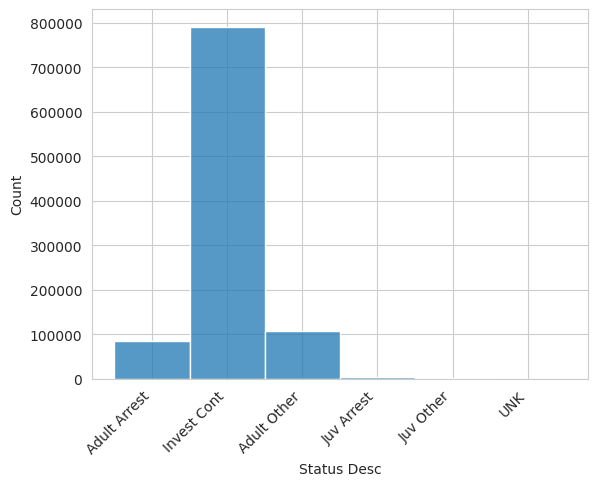

In [165]:
sns.histplot(x=df['Status Desc'],palette =59685)
plt.xticks(rotation=45, ha='right')
plt.show()

<ipython-input-166-7d2baecd2443>:1: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



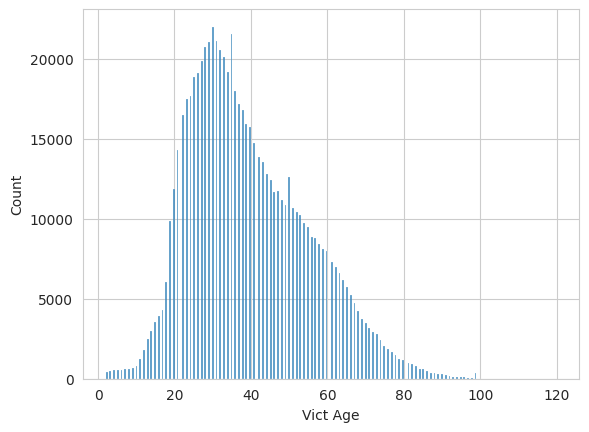

In [166]:
sns.histplot(x=df[df['Vict Age']>0]['Vict Age'],palette =59685)
plt.show()

<ipython-input-167-30566aeccbae>:2: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



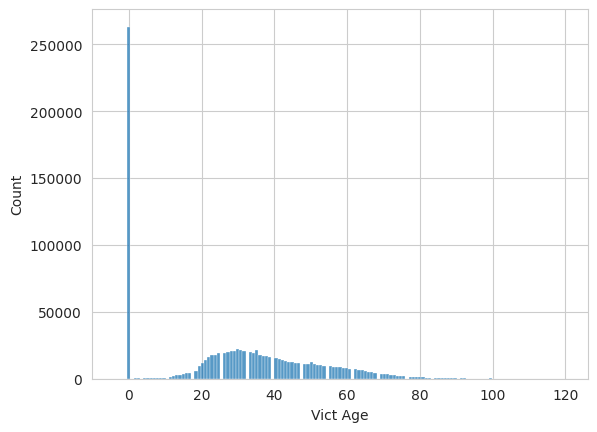

<ipython-input-167-30566aeccbae>:2: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



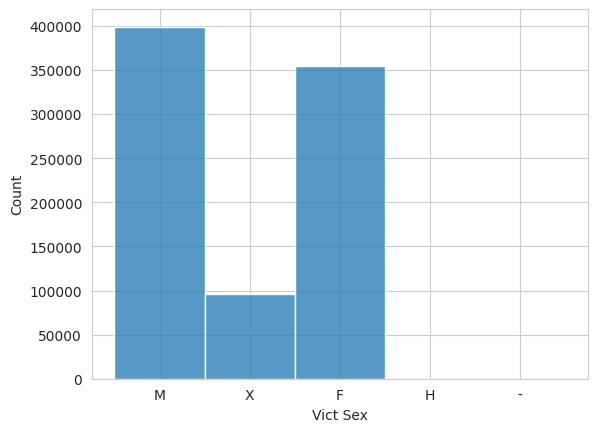

<ipython-input-167-30566aeccbae>:2: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



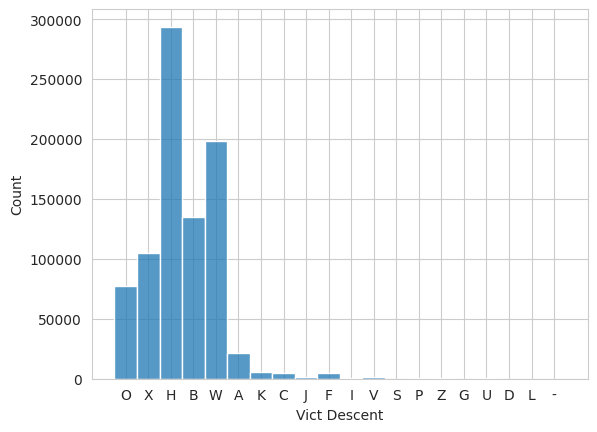

In [167]:
for i in df[['Vict Age', 'Vict Sex', 'Vict Descent']].columns:
    sns.histplot(x=df[i],palette =59685)
    plt.show()

In [168]:
df['Crm Cd Desc'].value_counts()[:10]

KeyError: 'Crm Cd Desc'

## Second Section

### General

<ipython-input-169-6e1beac57a9e>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




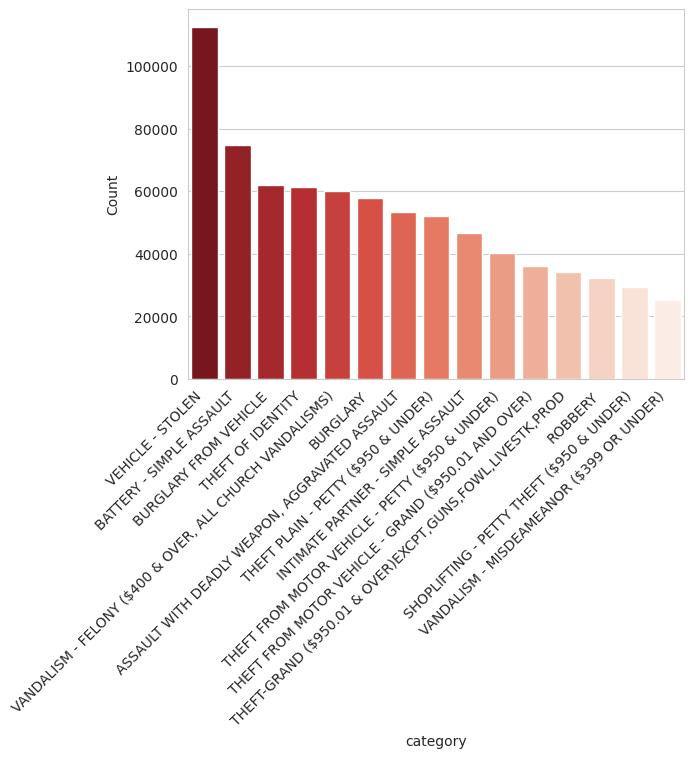

In [169]:
dff = df.groupby('category').count()[['no']].rename(columns={'no':'Count'})
dff = dff.sort_values('Count',ascending=False)[:15]
sns.barplot(x = dff.index, y = dff['Count'],palette="Reds_r")

plt.xticks(rotation=45, ha='right')

plt.show()

### Temporal Analysis

<ipython-input-170-3dfa08255f82>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-170-3dfa08255f82>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




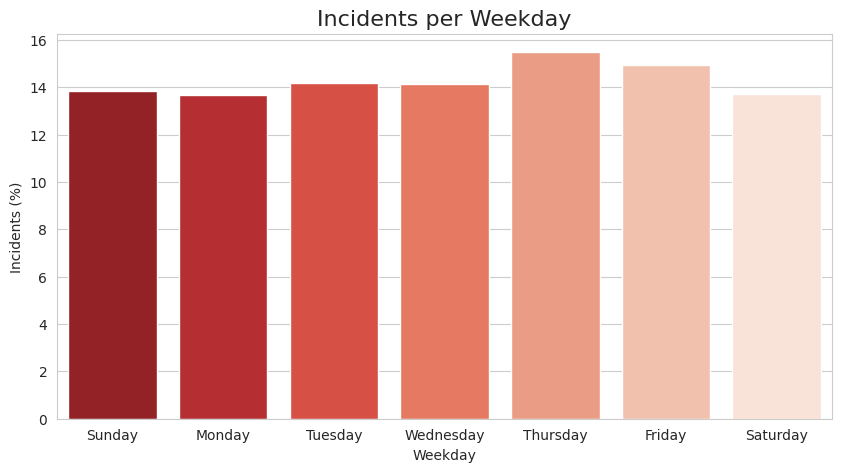

In [170]:
mapping = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday'}
data = df[df['category']== 'VEHICLE - STOLEN']
data['weekday_name'] = data['weekday'].map(mapping)

data = data.groupby(['weekday','weekday_name']).agg({'date occ':'count'}).reset_index().rename(columns={'date occ':'Incidents'}).sort_values('weekday',ascending=True)

plt.figure(figsize=(10, 5))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(x = data.weekday_name, y =(data.Incidents / data.Incidents.sum()) * 100,
        orient='v',
        palette="Reds_r")

plt.title('Incidents per Weekday', fontdict={'fontsize': 16})
plt.xlabel('Weekday')
plt.ylabel('Incidents (%)')

plt.show()

<ipython-input-171-be89afe5fb1a>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




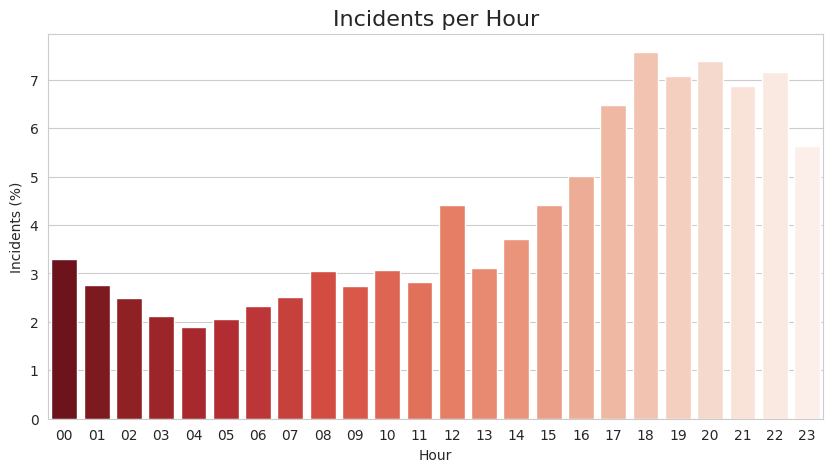

In [171]:
data = df[df['category']== 'VEHICLE - STOLEN']

data = data.groupby('hour').count()[['date occ']].rename(columns={'date occ':'Incidents'})

plt.figure(figsize=(10, 5))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(x = data.index, y =(data.Incidents / data.Incidents.sum()) * 100,
        orient='v',
        palette="Reds_r")

plt.title('Incidents per Hour', fontdict={'fontsize': 16})
plt.xlabel('Hour')
plt.ylabel('Incidents (%)')

plt.show()

<ipython-input-173-a6964b6a57e2>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-173-a6964b6a57e2>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




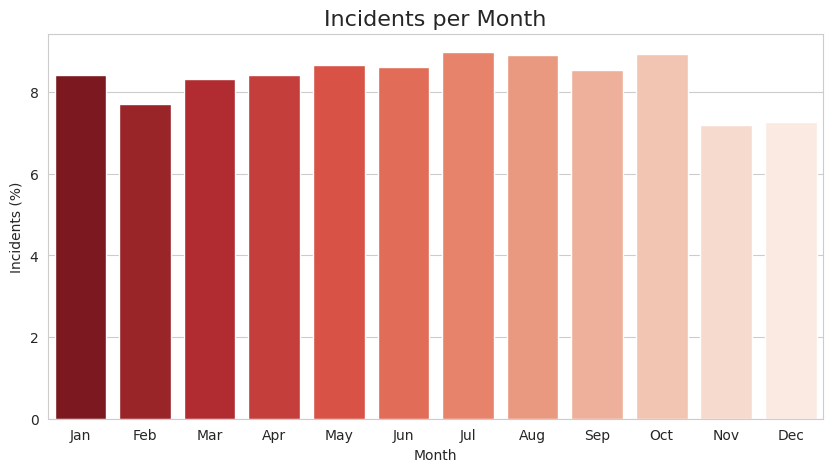

In [173]:
mapping = {1: 'Jan', 2: 'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7: 'Jul', 8: 'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
data = df[df['category']== 'VEHICLE - STOLEN']
data['month_name'] = data['month'].map(mapping)

data = data.groupby(['month','month_name']).agg({'date occ':'count'}).reset_index().rename(columns={'date occ':'Incidents'}).sort_values('month',ascending=True)

plt.figure(figsize=(10, 5))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(x = data.month_name, y =(data.Incidents / data.Incidents.sum()) * 100,
        orient='v',
        palette="Reds_r")

plt.title('Incidents per Month', fontdict={'fontsize': 16})
plt.xlabel('Month')
plt.ylabel('Incidents (%)')

plt.show()

<ipython-input-175-105c52020dcc>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




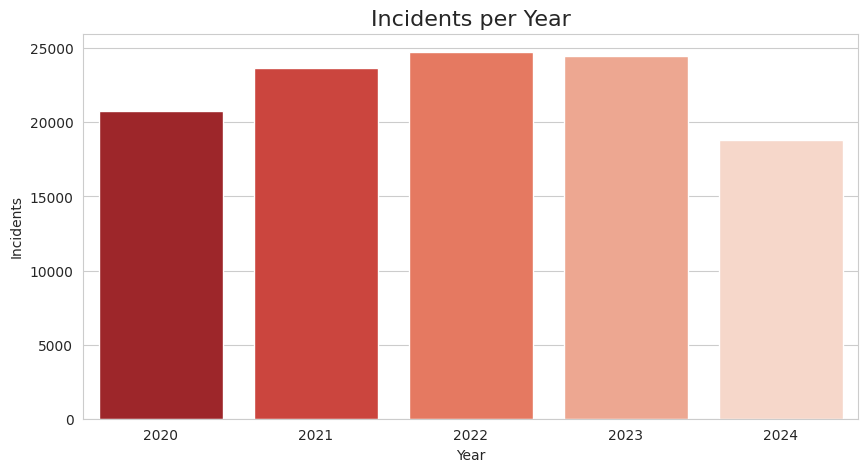

In [175]:
data = df[df['category']== 'VEHICLE - STOLEN']
data = data.groupby('year').count()[['date occ']].rename(columns={'date occ':'Incidents'})

plt.figure(figsize=(10, 5))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(x = data.index, y =data.Incidents,
        orient='v',
        palette="Reds_r")

plt.title('Incidents per Year', fontdict={'fontsize': 16})
plt.xlabel('Year')
plt.ylabel('Incidents')

plt.show()

<ipython-input-177-bae44574b10f>:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-177-bae44574b10f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-177-bae44574b10f>:7: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




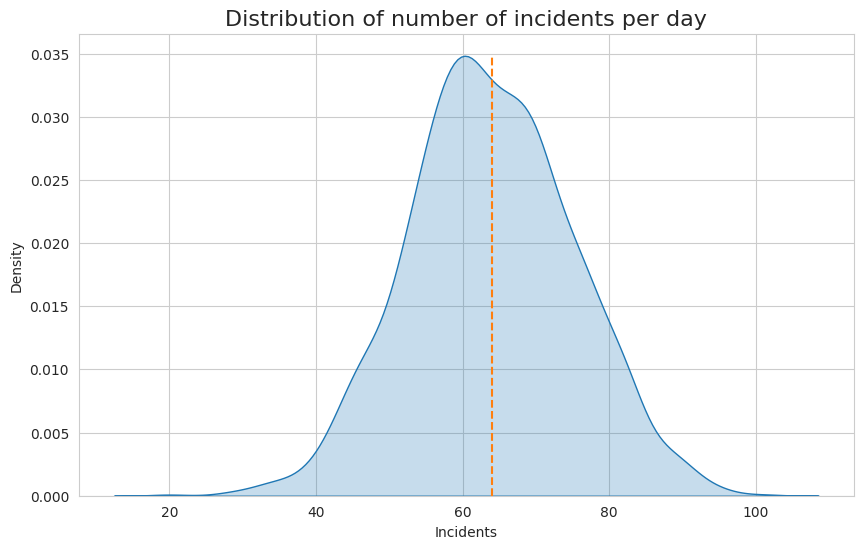

In [177]:
col = sns.color_palette()

plt.figure(figsize=(10, 6))
data = df[df['category']== 'VEHICLE - STOLEN']
data['date occ'] = pd.to_datetime(data['date occ']).dt.strftime("%m/%d/%Y")
data = data.groupby('date occ').count().iloc[:, 0]
sns.kdeplot(data=data, shade=True)
plt.axvline(x=data.median(), ymax=0.95, linestyle='--', color=col[1])

plt.title(
    'Distribution of number of incidents per day', fontdict={'fontsize': 16})
plt.xlabel('Incidents')
plt.ylabel('Density')
plt.legend().remove()
plt.show()

### Animation

In [9]:
df[df['lat']> 1][df['lon'] < -1][['lat','lon']].describe()

<ipython-input-9-cda7fc51baee>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



lat            lon
count  987744.000000  987744.000000
mean       34.074169    -118.354659
std         0.111172       0.104444
min        33.705900    -118.667600
25%        34.015200    -118.430900
50%        34.059200    -118.322900
75%        34.164900    -118.274000
max        34.334300    -118.155400

<ipython-input-10-51bcc645df0a>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



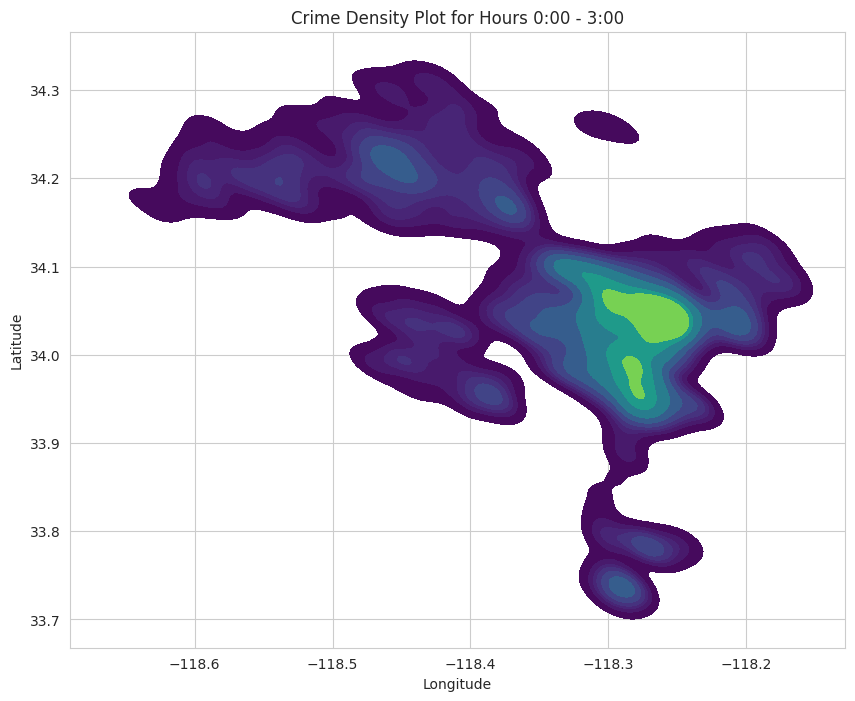

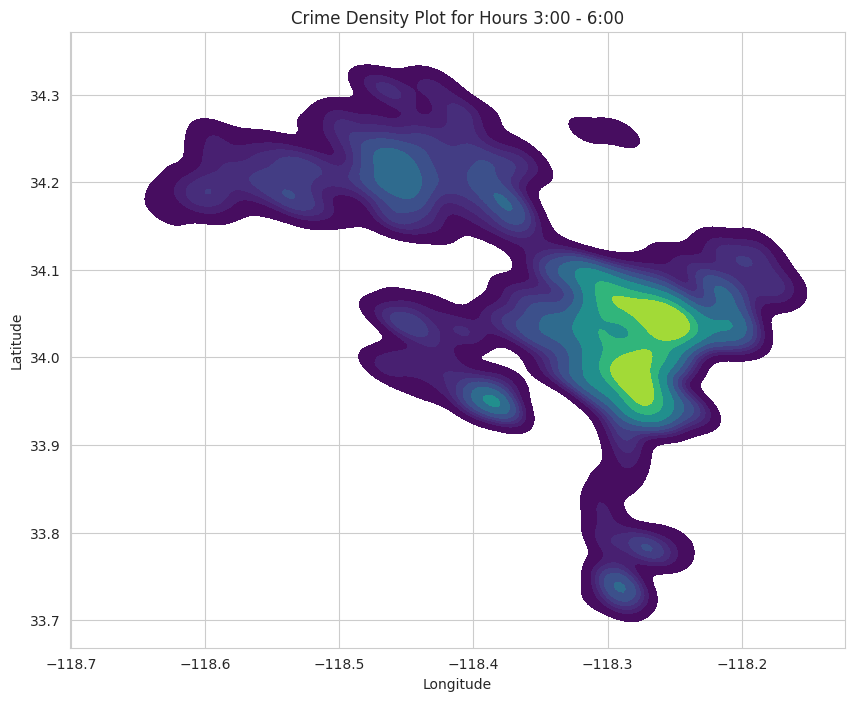

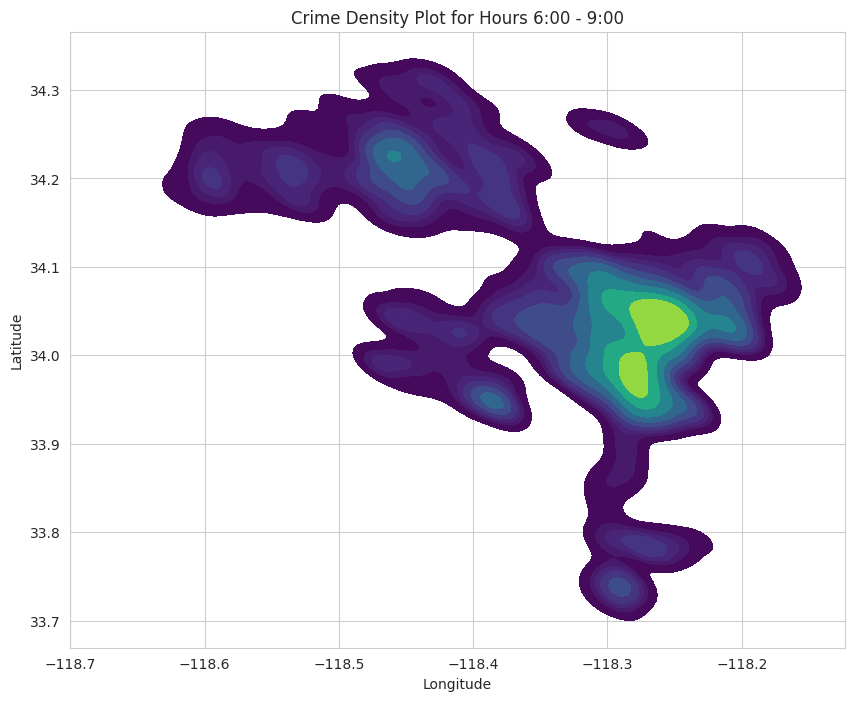

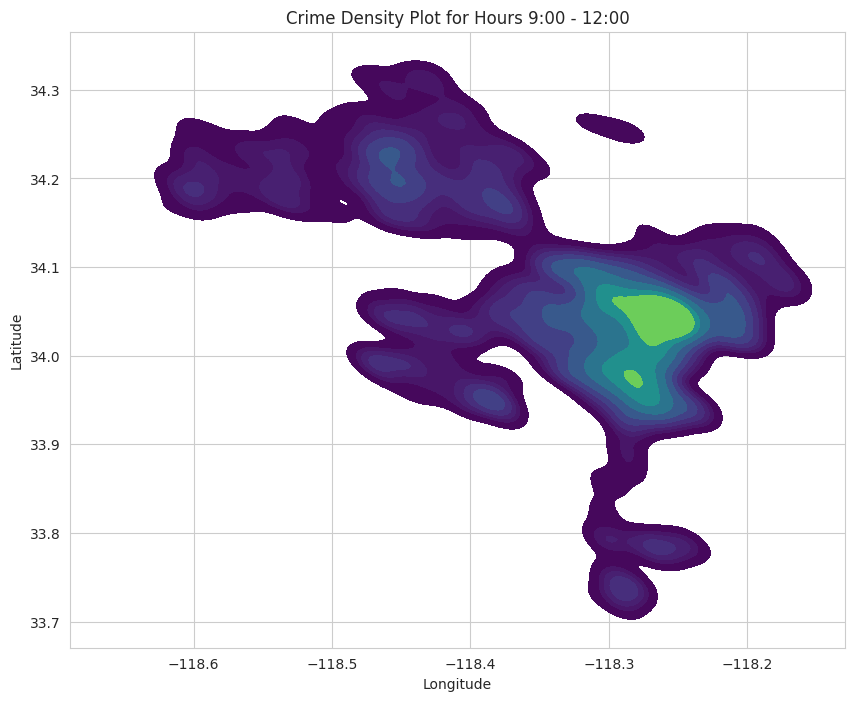

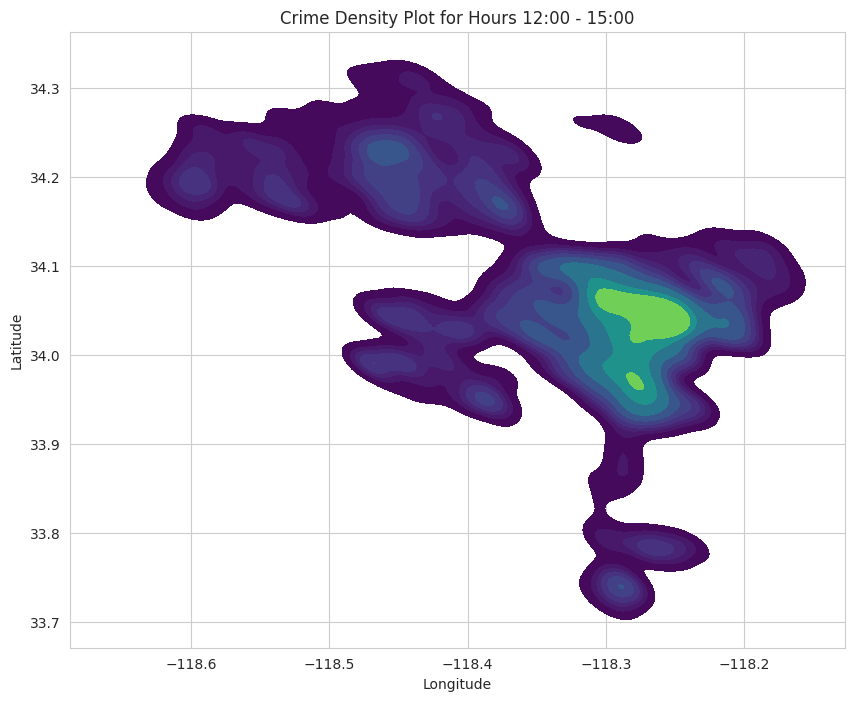

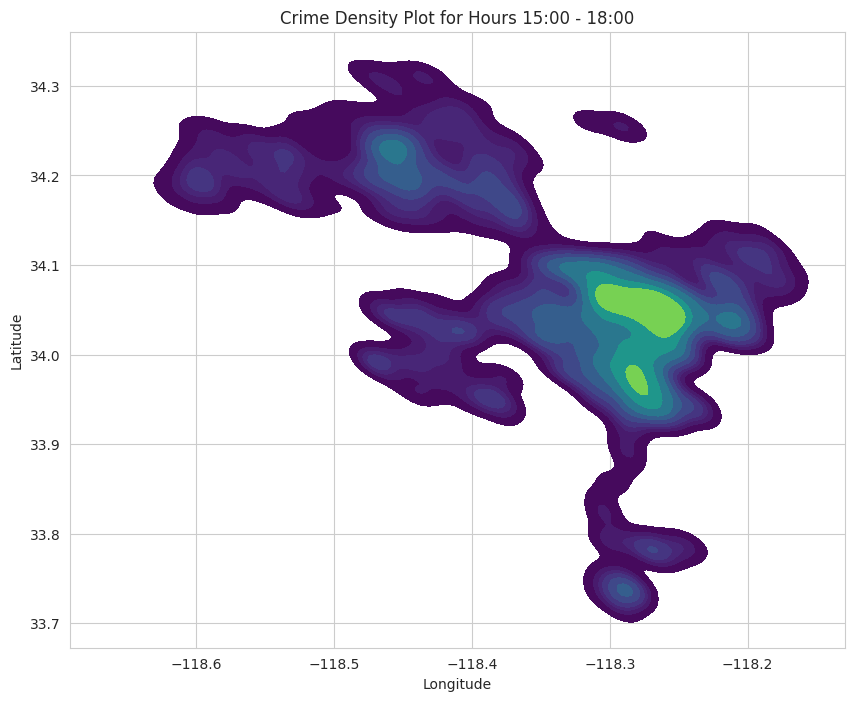

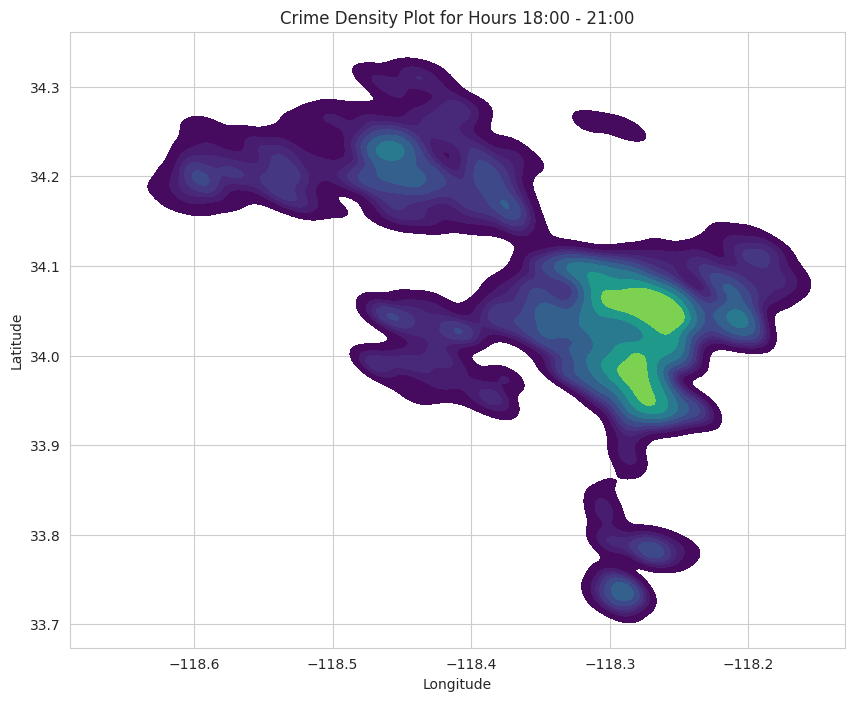

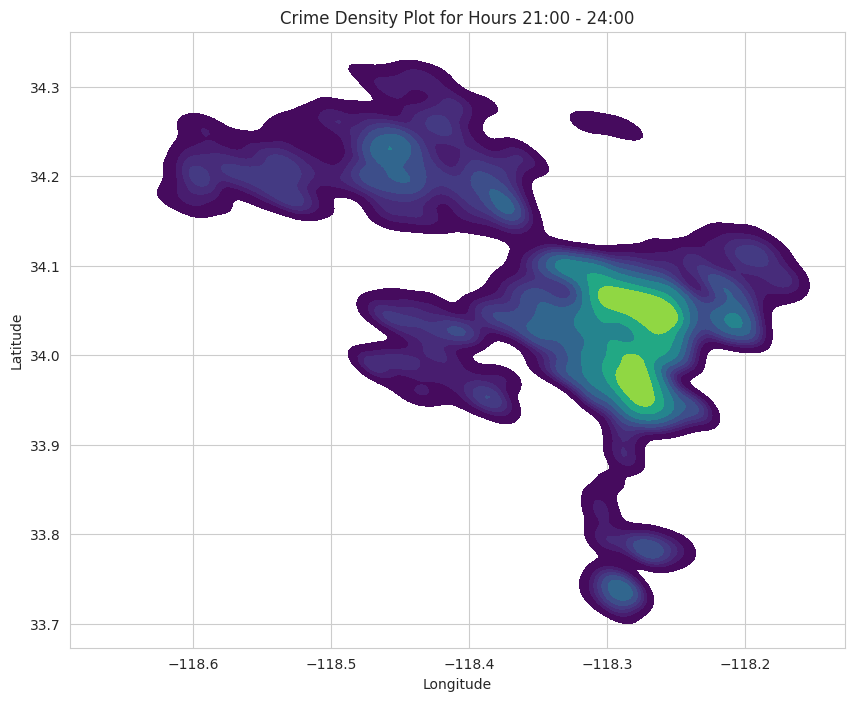

In [10]:
dff = df[df['category'] == 'VEHICLE - STOLEN']
dff = dff[dff['lat']> 1][dff['lon'] < -1]
# Define time windows and filter data for each window
time_windows = [(0, 3), (3, 6), (6, 9), (9, 12), (12, 15), (15, 18), (18, 21), (21, 24)]

for start, end in time_windows:
    plt.figure(figsize=(10, 8))
    window_data = dff[(dff['hour'].astype(int) >= start) & (dff['hour'].astype(int) < end)]

    # Plot density plot
    sns.kdeplot(data=window_data, x='lon', y='lat', fill=True, cmap="viridis", bw_adjust=0.5)
    plt.title(f'Crime Density Plot for Hours {start}:00 - {end}:00')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

<ipython-input-11-bf90b6c8f865>:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



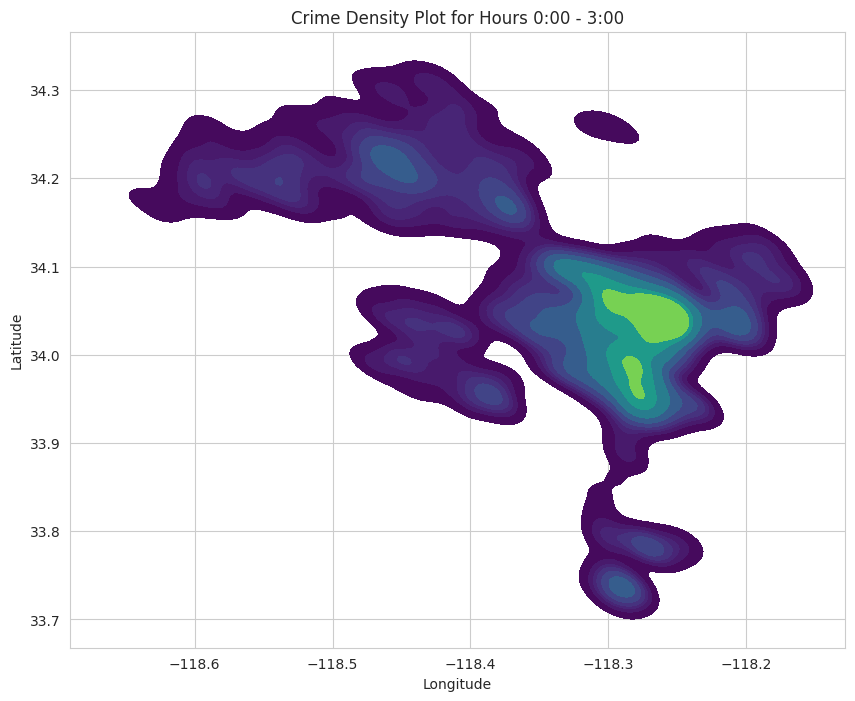

In [11]:
import matplotlib.animation as animation

dff = df[df['category'] == 'VEHICLE - STOLEN']
dff = dff[dff['lat']> 1][dff['lon'] < -1]

fig, ax = plt.subplots(figsize=(10, 8))

def animate(time_window):
    ax.clear()
    start, end = time_windows[time_window]
    window_data = dff[(dff['hour'].astype(int) >= start) & (dff['hour'].astype(int) < end)]
    sns.kdeplot(data=window_data, x='lon', y='lat', fill=True, cmap="viridis", ax=ax, bw_adjust=0.5)
    ax.set_title(f'Crime Density Plot for Hours {start}:00 - {end}:00')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

ani = animation.FuncAnimation(fig, animate, frames=len(time_windows), interval=1000)
ani.save('crime_density_animation.gif', writer='ffmpeg')

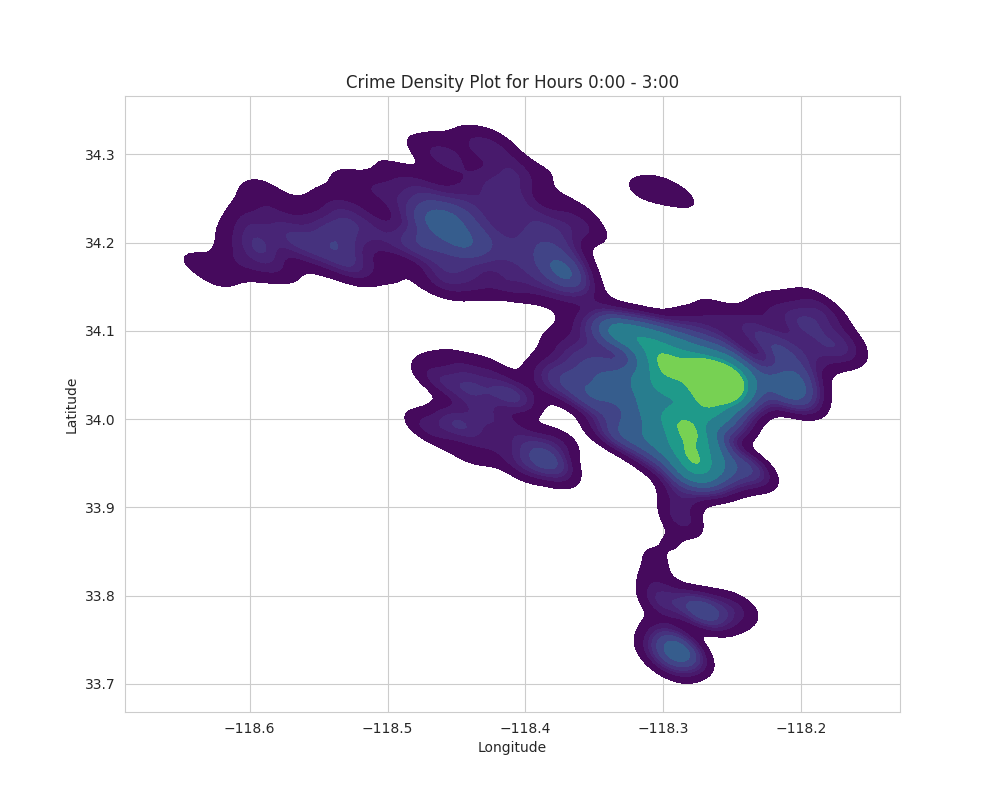

In [13]:
from IPython.display import Image

# Display the GIF in Jupyter Notebook
Image(filename="crime_density_animation.gif")

#### With Street Map

In [15]:
dff = df[df['category'] == 'VEHICLE - STOLEN']
dff = dff[dff['lat']> 1][dff['lon'] < -1]

# Ensure 'latitude', 'longitude', 'hour' (or time_window) columns in your DataFrame
dff['time_window'] = dff['hour'].astype(int) // 3  # Example: grouping by 3-hour windows for time segmentation
dff.head()

<ipython-input-15-5e651c85464d>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



no             date report                date occ time occ  \
0   190326475  03/01/2020 12:00:00 AM  03/01/2020 12:00:00 AM    21:30   
13  221008844  05/06/2022 12:00:00 AM  11/01/2020 12:00:00 AM    01:30   
23  200412582  09/09/2020 12:00:00 AM  09/09/2020 12:00:00 AM    06:30   
27  200209713  05/03/2020 12:00:00 AM  05/02/2020 12:00:00 AM    18:00   
77  201810154  04/26/2020 12:00:00 AM  04/22/2020 12:00:00 AM    19:00   

    area code         area  Rpt Dist No  Part 1-2  Crm Cd          category  \
0           7     Wilshire          784         1     510  VEHICLE - STOLEN   
13         10  West Valley         1029         1     510  VEHICLE - STOLEN   
23          4   Hollenbeck          413         1     510  VEHICLE - STOLEN   
27          2      Rampart          245         1     510  VEHICLE - STOLEN   
77         18    Southeast         1802         1     510  VEHICLE - STOLEN   

    ...      lat       lon               lon_lat day  month  year  weekday  \
0   ...  34.0375 -118.3506  [-118.3506, 34.0375]   1      3  2020        6   
13  ...  34.1939 -118.4859  [-118.4859, 34.1939]   1     11  2020        6   
23  ...  34.0820 -118.2130    [-118.213, 34.082]   9      9  2020        2   
27  ...  34.0642 -118.2771  [-118.2771, 34.0642]   2      5  2020        5   
77  ...  33.9547 -118.2717  [-118.2717, 33.9547]  22      4  2020        2   

   hour minute time_window  
0    21     30           7  
13   01     30           0  
23   06     30           2  
27   18     00           6  
77   19     00           6  

[5 rows x 36 columns]

<ipython-input-16-6358caa23c12>:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

Error writing trailer of crime_density_animation.gif: Invalid argument



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x800', '-pix_fmt', 'rgba', '-framerate', '1.0', '-loglevel', 'error', '-i', 'pipe:', '-filter_complex', 'split [a][b];[a] palettegen [p];[b][p] paletteuse', '-y', 'crime_density_animation.gif']' returned non-zero exit status 255.

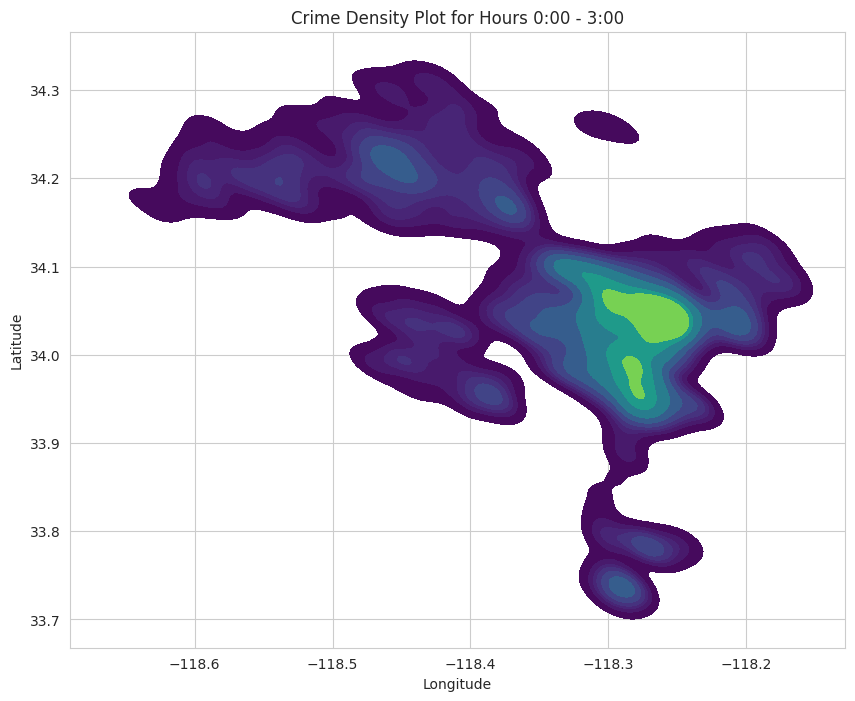

In [16]:
dff = df[df['category'] == 'VEHICLE - STOLEN']
dff = dff[dff['lat']> 1][dff['lon'] < -1]

# Ensure 'latitude', 'longitude', 'hour' (or time_window) columns in your DataFrame
dff['time_window'] = dff['hour'].astype(int) // 3  # Example: grouping by 3-hour windows for time segmentation

# Create density map with animation
fig = px.density_mapbox(
    dff, lat='lat', lon='lon', z='incident_count', radius=10,
    animation_frame="time_window",  # Column to animate over time
    center=dict(lat=34.05, lon=-118.25),  # Adjust for your data's center (e.g., Los Angeles)
    zoom=10, mapbox_style="open-street-map",  # Use "carto-positron" or others as needed
    title="Crime Density Animation on Street Map"
)
fig.update_layout(mapbox_accesstoken="your_mapbox_token")
fig.show()


#### With basemap

In [18]:
!pip install contextily
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 75.0 MB/s eta 0:00:00


<ipython-input-26-3b63cbf87d3f>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



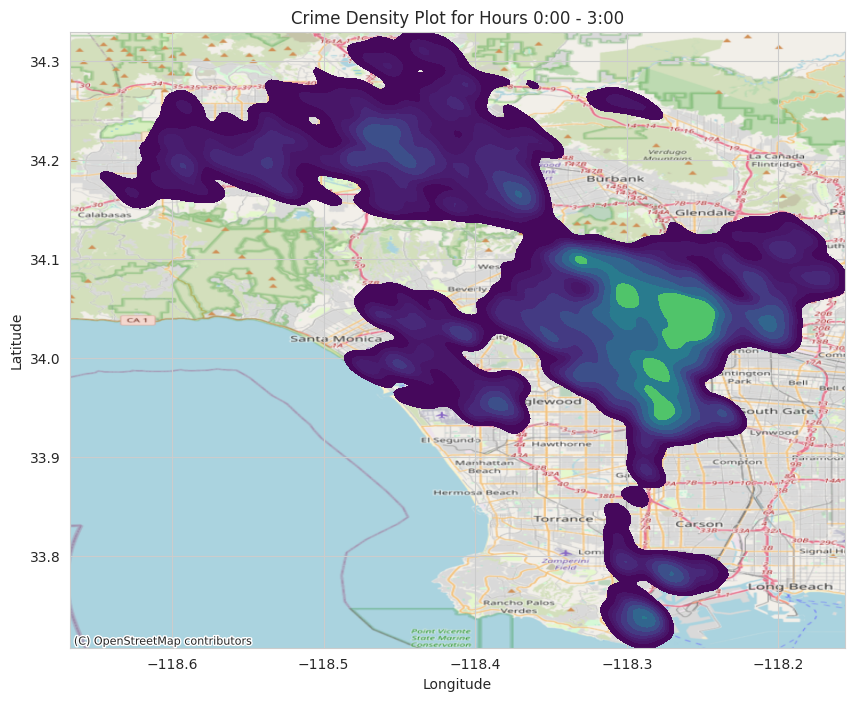

In [26]:
dff = df[df['category'] == 'VEHICLE - STOLEN']
dff = dff[dff['lat']> 1][dff['lon'] < -1]

fig, ax = plt.subplots(figsize=(10, 8))
bbox = (min(dff['lon']), min(dff['lat']), max(dff['lon']), max(dff['lat']))

def animate(time_window):
    ax.clear()
    start, end = time_windows[time_window]
    window_data = dff[(dff['hour'].astype(int) >= start) & (dff['hour'].astype(int) < end)]
    sns.kdeplot(data=window_data, x='lon', y='lat', fill=True, cmap="viridis", ax=ax, bw_adjust=0.3)
    ax.set_title(f'Crime Density Plot for Hours {start}:00 - {end}:00')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Add the basemap with contextily
    ax.set_xlim(bbox[0], bbox[2])
    ax.set_ylim(bbox[1], bbox[3])
    ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik)

ani = animation.FuncAnimation(fig, animate, frames=len(time_windows), interval=1000)
ani.save('crime_density_animation.gif', writer='ffmpeg')

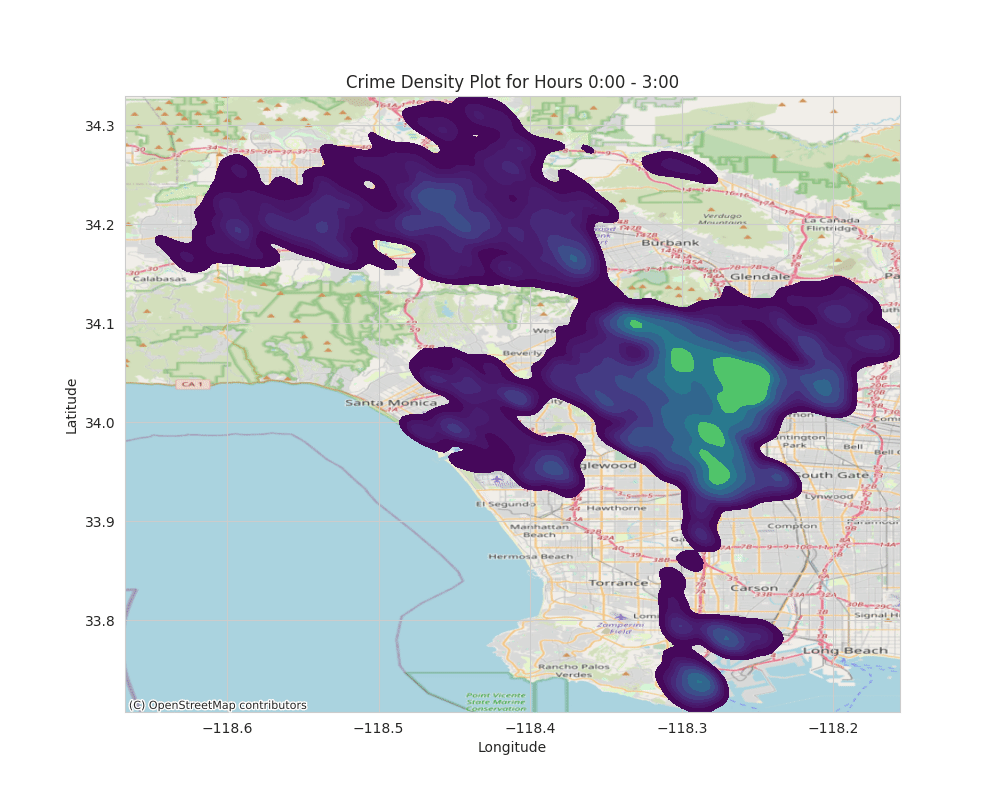

In [27]:
# Display the GIF in Jupyter Notebook
Image(filename="crime_density_animation.gif")

### Spatial Analysis

In [140]:
dff = df[df['category'] == 'VEHICLE - STOLEN']
dff['neighbourhood'] = dff['lon_lat']
dic = {}

for i in df_geo.iterrows():
    polygon = Polygon(i[1][1])
    for j in dff.iterrows():
      if polygon.contains(Point(j[1][35])):
            dic[j[0]] = i[1][0]

<ipython-input-140-3afabb5cfd29>:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-140-3afabb5cfd29>:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-140-3afabb5cfd29>:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [ ]:
# Iterate using `itertuples` for `df_geo`
for geo_row in df_geo.itertuples():
    polygon = Polygon(geo_row[2])
    for dff_row in dff.itertuples():
        if polygon.contains(Point(dff_row[36])):
            dic[dff_row.Index] = geo_row[1]

In [145]:
df_n = pd.DataFrame.from_dict([dic.keys(),dic.values()]).transpose()
df_n.columns = ['Index','neighbourhood_name']
df_n = df_n.set_index('Index')
dff_loc = pd.merge(dff,df_n,left_index=True, right_index=True)

In [146]:
for feature in la_districts['features']:
    feature['id'] = feature['properties']['name']

In [148]:
#df['id'] = df['neighbourhood_name']
df_map = dff_loc.groupby('neighbourhood_name').count()[['no']].reset_index()
df_map['id'] = df_map['neighbourhood_name']
df_map.rename(columns={'no':'Count'},inplace=True)
df_map['CountDensity'] = np.log10(df_map['Count'])

In [149]:
#Crime Density
fig = px.choropleth_mapbox(df_map, geojson=la_districts, color="CountDensity",
                           locations="id",
                           center=dict(lat=34.052235,lon=-118.243683),
                           mapbox_style="carto-positron", zoom=8.3)
fig.update_geos(fitbounds='locations',visible = False)
fig.show()

In [116]:
#Crime Density
data = df[df['category'] == 'VEHICLE - STOLEN']
fig = px.density_mapbox(data, lat='lat', lon='lon', radius=1,
                        center=dict(lat=34.052235,lon=-118.243683), zoom=9,
                        mapbox_style="open-street-map")
                        #mapbox_style="stamen-terrain")
#fig.update_geos(fitbounds='locations',visible = False)
fig.show()

# Transform from load

In [10]:
df = pd.read_csv('/content/drive/My Drive/Portfolio Projects/Crime Data - Los Angeles/neighbourhood_checkpoint.csv')

In [11]:
def load_transform(df):
    #Get dates
    df['day'] = pd.to_datetime(df['DATE OCC']).dt.day
    df['month'] = pd.to_datetime(df['DATE OCC']).dt.month
    df['year'] = pd.to_datetime(df['DATE OCC']).dt.year
    df['weekday'] = pd.to_datetime(df['DATE OCC']).dt.weekday
    df['TIME OCC'] = df['TIME OCC'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
    df['TIME OCC'] = df['TIME OCC'].astype(str).apply(lambda x:x[:-2] + ":" + x[-2:])
    #df['TIME OCC'] = df['TIME OCC'].astype(str).apply(lambda x: x[:-1] + "0" + x[-1:] if len(x) == 2 else x)
    df['TIME OCC'] = df['TIME OCC'].astype(str).apply(lambda x: '0' + x if len(x) == 3 else x)
    df['TIME OCC'] = df['TIME OCC'].astype(str).apply(lambda x: '0' + x if len(x) == 4 else x)
    df['hour'] = df['TIME OCC'].astype(str).apply(lambda x:x[:2])
    df['minute'] = df['TIME OCC'].astype(str).apply(lambda x:x[-2:])

    df['Dates'] = df['Date Rptd'].astype(str).apply(lambda x: x[:-11]) + df['TIME OCC'].astype(str).apply(lambda x: x[-5:])
    df['Dates'] = pd.to_datetime(df['Dates'])

    df.drop('TIME OCC',axis=1,inplace=True)
    df.drop('DATE OCC',axis=1,inplace=True)
    df.drop('Date Rptd',axis=1,inplace=True)

    df.rename(columns={'Crm Cd Desc':'Category'},inplace=True)

    df.drop(['neighbourhood','neighbourhood_name','Vict Age', 'Vict Sex',
       'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd','Unnamed: 0'],axis=1,inplace=True)
    df.drop([ 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4','Weapon Desc', 'Status', 'Status Desc'],axis=1,inplace=True)
    df.drop(['Rpt Dist No', 'Part 1-2', 'Crm Cd','Mocodes'],axis=1,inplace=True)
    df.drop(['AREA','DR_NO'],axis=1,inplace=True)

    df.drop(['LOCATION', 'Cross Street','lon_lat'],axis=1,inplace=True)

    df.rename(columns={'AREA NAME':'Area'},inplace=True)
    df.rename(columns={'id':'District'},inplace=True)

    dff = df.copy()
    dff['index'] = dff.index
    dff = dff.groupby(['Area','Category']).count()[['index']].rename(columns={'index':'Area Count'})
    df = pd.merge(df.set_index(['Area','Category']),dff, left_index= True,right_index= True,how='left').reset_index()

    dff = df.copy()
    dff['index'] = dff.index
    dff = dff.groupby(['District','Category']).count()[['index']].rename(columns={'index':'District Count'})
    df = pd.merge(df.set_index(['District','Category']),dff, left_index= True,right_index= True,how='left').reset_index()

    df['Dates'] = df['Dates'].astype(np.int64)

    #Calculate common crimes
    dff = df.copy()
    dff['index'] = dff.index
    dff = dff.groupby('Category').count()[['index']].rename(columns={'index':'Count'})
    dff = dff.sort_values('Count',ascending=False)[:10]
    Common_crimes = dff.index

    df = df[df['Category'].isin(Common_crimes)]

    return df

In [12]:
df = load_transform(df)

<ipython-input-11-0a62be225c1d>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['day'] = pd.to_datetime(df['DATE OCC']).dt.day
<ipython-input-11-0a62be225c1d>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month'] = pd.to_datetime(df['DATE OCC']).dt.month
<ipython-input-11-0a62be225c1d>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['year'] = pd.to_datetime(df['DATE OCC']).dt.year
<ipython-input-11-0a62be225c1d>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and 

In [16]:
#Test set share of observations
len(df[df['year'] == 2023])/len(df['year'])

0.11217132199071968

In [16]:
def yencoder(X,y):
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_Y = encoder.transform(y)
    # convert integers to dummy variables (i.e. one hot encoded)
    dummy_y = to_categorical(encoded_Y)

    X = np.asarray(X).astype('float32')
    y = to_categorical(dummy_y)
    return X, y

In [17]:
def transformation_dl(df):
    df_train = df[df['year'] < 2023]
    df_test = df[df['year'] == 2023]

    X_train = df_train.iloc[:,3:]
    y_train = df_train.iloc[:,1]
    X_test = df_test.iloc[:,3:]
    y_test = df_test.iloc[:,1]

    X_train, y_train = yencoder(X_train, y_train)
    X_test, y_test = yencoder(X_test, y_test)

    return (X_train, y_train, X_test, y_test)

In [18]:
X_train_dl, y_train_dl, X_test_dl, y_test_dl = transformation_dl(df)

In [21]:
def factorize_rf(df):
    #Factorize
    factor = pd.factorize(df['Category'])
    df['Category'] = factor[0]
    definitions = factor[1]
    return df,definitions

In [22]:
def transformation_rf(df):
    df, definitions = factorize_rf(df)

    df_train = df[df['year'] < 2023]
    df_test = df[df['year'] == 2023]

    X = df.iloc[:,3:]
    y = df.iloc[:,1]

    X_train = df_train.iloc[:,3:]
    y_train = df_train.iloc[:,1]
    X_test = df_test.iloc[:,3:]
    y_test = df_test.iloc[:,1]

    return (X_train, y_train, X_test, y_test, definitions)

In [23]:
X_train_rf, y_train_rf, X_test_rf, y_test_rf, definitions_rf = transformation_rf(df)

In [24]:
X_train_rf.head()

LAT       LON  day  month  year  weekday hour minute  \
0   34.0141 -118.2978    8      1  2020        2   22     30   
1   34.0459 -118.2545    1      1  2020        2   03     30   
4   34.2198 -118.4468    1      1  2020        2   04     15   
10  34.0359 -118.2648    4      1  2020        5   22     00   
15  34.3055 -118.4439   30     11  2020        0   07     30   

                  Dates  Area Count  District Count  
0   1578522600000000000        3464             751  
1   1577935800000000000        5240            5437  
4   1577852100000000000        1663             535  
10  1578175200000000000        6682            7147  
15  1637911800000000000        1954             584

# Analysis

In [26]:
dff = df.groupby('Category').count()[['DR_NO']].rename(columns={'DR_NO':'Count'})
dff = dff.sort_values('Count',ascending=False)[:15]
sns.barplot(x = dff.index, y = dff['Count'],palette="Reds_r")

plt.xticks(rotation=45, ha='right')

plt.show()

KeyError: "None of [Index(['no'], dtype='object')] are in the [columns]"

In [27]:
df.head()

District  Category       Area      LAT       LON  day  month  year  \
0   Exposition Park         0  Southwest  34.0141 -118.2978    8      1  2020   
1          Downtown         0    Central  34.0459 -118.2545    1      1  2020   
4     Panorama City         1    Mission  34.2198 -118.4468    1      1  2020   
10         Downtown         2    Central  34.0359 -118.2648    4      1  2020   
15           Sylmar         3    Mission  34.3055 -118.4439   30     11  2020   

    weekday hour minute                Dates  Area Count  District Count  
0         2   22     30  1578522600000000000        3464             751  
1         2   03     30  1577935800000000000        5240            5437  
4         2   04     15  1577852100000000000        1663             535  
10        5   22     00  1578175200000000000        6682            7147  
15        0   07     30  1637911800000000000        1954             584